### Capstone Project Code 

#### The Neigborhood Clustering 

##### This notebook contains a code for my Capstone Project (Coursera) IBM 

In [3]:
import requests # library to handle requests
from bs4 import BeautifulSoup
import pandas as pd
import json # library to handle JSON files
import geocoder 
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline
# import k-means from clustering stage
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
#!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

<h4>Making a request to get the data from healthysf website and then create a dataframe using pandas

In [4]:
response = requests.get("http://www.healthysf.org/bdi/outcomes/zipmap.htm")
soup = BeautifulSoup(response.text, "lxml")
table = soup.find_all("table")
df = pd.read_html(str(table))
df = pd.DataFrame(df[4])

Getting rid of unnecessary coloumns and reshape the dataframe

In [5]:
df.columns = df.iloc[0]
df = df.iloc[1:-1, :-1]
sf_data = df
sf_data.head()


,Zip Code,Neighborhood
1,94102,Hayes Valley/Tenderloin/North of Market
2,94103,South of Market
3,94107,Potrero Hill
4,94108,Chinatown
5,94109,Polk/Russian Hill (Nob Hill)


<h4>Adding the latitude and longitude to the dataframe

In [6]:
#Creating a function to get the latitude longitude data from the Zip Code
def get_geocoder(zip_code_from_df):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, San Francsico, CA'.format(zip_code_from_df.strip()))
        lat_lng_coords = g.latlng
        latitude = lat_lng_coords[0]
        longitude = lat_lng_coords[1]
    return latitude,longitude

In [7]:
sf_data['Latitude'], sf_data['Longitude'] = zip(*sf_data['Zip Code'].apply(get_geocoder))

In [8]:
sf_data.head()

,Zip Code,Neighborhood,Latitude,Longitude
1,94102,Hayes Valley/Tenderloin/North of Market,37.777015,-122.421875
2,94103,South of Market,37.772000,-122.408735
3,94107,Potrero Hill,37.760651,-122.394064
4,94108,Chinatown,37.791775,-122.407440
5,94109,Polk/Russian Hill (Nob Hill),37.790105,-122.420590


#### Use geopy library to get the latitude and longitude values of San Francisco City.

In [9]:
#In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent sf_explorer.
address = 'San Francisco'

geolocator = Nominatim(user_agent = "sf_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of San Francisco are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of San Francisco are 37.7790262, -122.4199061.


<h4>Generate a map for San Francisco Neighborhoods

In [10]:
#Show an initial map of the neighborhoods in San Francisco
# create map of San Francisco using first entries latitude and longitude values
sf_map = folium.Map(location = [latitude, longitude], zoom_start=10)

# add markers to map
for lat, long, neighborhood in zip(sf_data['Latitude'], sf_data['Longitude'], sf_data['Neighborhood']):
    label = '{}'.format(neighborhood,)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(sf_map)  
    
sf_map

<h4>Use Four Square API to Explore

Adding the Credentials along with the version for the API

In [11]:
CLIENT_ID = 'JXN1VB3P4QVDCKY2IPYOVK5UTEFFNBZH4BEZGZS3MXVD2UPO' # Foursquare ID
CLIENT_SECRET = 'D0KSS5SG11FZSROV02POMJIMRVBG4LUXUWGLU1IVLJOKKEJI' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JXN1VB3P4QVDCKY2IPYOVK5UTEFFNBZH4BEZGZS3MXVD2UPO
CLIENT_SECRET:D0KSS5SG11FZSROV02POMJIMRVBG4LUXUWGLU1IVLJOKKEJI


<h4>Creating a method to get the data in a more generalized form and we can easily recall

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=500,LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

<h4>Get Venue Data from Foursquare for all neighborhoods

In [13]:
sf_venues_df = getNearbyVenues(names = sf_data['Neighborhood'],
                                   latitudes = sf_data['Latitude'],
                                   longitudes = sf_data['Longitude']
                                  )
                                  
sf_venues_df.head()

Hayes Valley/Tenderloin/North of Market
South of Market
Potrero Hill
Chinatown
Polk/Russian Hill (Nob Hill)
Inner Mission/Bernal Heights
Ingelside-Excelsior/Crocker-Amazon
Castro/Noe Valley
Western Addition/Japantown
Parkside/Forest Hill
Haight-Ashbury
Inner Richmond
Outer Richmond
Sunset
Marina
Bayview-Hunters Point
St. Francis Wood/Miraloma/West Portal
Twin Peaks-Glen Park
Lake Merced
North Beach/Chinatown
Visitacion Valley/Sunnydale


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Hayes Valley/Tenderloin/North of Market,37.777015,-122.421875,SFJazz Center,37.776350,-122.421539,Jazz Club
1,Hayes Valley/Tenderloin/North of Market,37.777015,-122.421875,Blue Bottle Coffee,37.776430,-122.423224,Coffee Shop
2,Hayes Valley/Tenderloin/North of Market,37.777015,-122.421875,Louise M. Davies Symphony Hall,37.777976,-122.420157,Concert Hall
3,Hayes Valley/Tenderloin/North of Market,37.777015,-122.421875,Linden Alley,37.776329,-122.423594,Pedestrian Plaza
4,Hayes Valley/Tenderloin/North of Market,37.777015,-122.421875,Fatted Calf,37.775935,-122.423146,Butcher


In [14]:
sf_venues_df.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bayview-Hunters Point,21,21,21,21,21,21
Castro/Noe Valley,79,79,79,79,79,79
Chinatown,86,86,86,86,86,86
Haight-Ashbury,81,81,81,81,81,81
Hayes Valley/Tenderloin/North of Market,100,100,100,100,100,100
Ingelside-Excelsior/Crocker-Amazon,47,47,47,47,47,47
Inner Mission/Bernal Heights,30,30,30,30,30,30
Inner Richmond,53,53,53,53,53,53
Lake Merced,23,23,23,23,23,23


In [15]:
print('There are {} uniques categories.'.format(len(sf_venues_df['Venue Category'].unique())))

There are 236 uniques categories.


<h4>Neighborhood analyzing

In [16]:
# one hot encoding
sf_onehot = pd.get_dummies(sf_venues_df[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sf_onehot['Neighborhood'] = sf_venues_df['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [sf_onehot.columns[-1]] + list(sf_onehot.columns[:-1])
sf_onehot = sf_onehot[fixed_columns]

sf_onehot.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,African Restaurant,Alternative Healer,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,...,Tuscan Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Hayes Valley/Tenderloin/North of Market,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Hayes Valley/Tenderloin/North of Market,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Hayes Valley/Tenderloin/North of Market,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Hayes Valley/Tenderloin/North of Market,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Hayes Valley/Tenderloin/North of Market,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Grouping rows by neighborhood and taking the mean of the frequency of occurrence of each category

In [17]:
sf_grouped = sf_onehot.groupby('Neighborhood').mean().reset_index()
sf_grouped.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,African Restaurant,Alternative Healer,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,...,Tuscan Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Bayview-Hunters Point,0.0,0.000000,0.000000,0.047619,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1,Castro/Noe Valley,0.0,0.000000,0.012658,0.000000,0.0,0.012658,0.000000,0.0,0.012658,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.025316,0.012658,0.000000,0.025316
2,Chinatown,0.0,0.000000,0.000000,0.000000,0.0,0.034884,0.000000,0.0,0.000000,...,0.0,0.0,0.011628,0.0,0.023256,0.0,0.000000,0.000000,0.000000,0.011628
3,Haight-Ashbury,0.0,0.024691,0.000000,0.000000,0.0,0.012346,0.012346,0.0,0.000000,...,0.0,0.0,0.012346,0.0,0.012346,0.0,0.012346,0.000000,0.012346,0.012346
4,Hayes Valley/Tenderloin/North of Market,0.0,0.010000,0.000000,0.000000,0.0,0.010000,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.010000,0.0,0.050000,0.010000,0.000000,0.010000


#### Printing each neighborhood along with the top 10 most common venues

In [18]:
num_top_venues = 10

for hood in sf_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = sf_grouped[sf_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bayview-Hunters Point----
                             venue  freq
0                             Park  0.19
1  Southern / Soul Food Restaurant  0.10
2                      Bus Station  0.05
3                       Playground  0.05
4              Fried Chicken Joint  0.05
5                          Theater  0.05
6                    Grocery Store  0.05
7                   Baseball Field  0.05
8               Mexican Restaurant  0.05
9                           Bakery  0.05


----Castro/Noe Valley----
                venue  freq
0             Gay Bar  0.11
1         Coffee Shop  0.05
2     Thai Restaurant  0.04
3                Park  0.04
4         Yoga Studio  0.03
5  Seafood Restaurant  0.03
6   Indian Restaurant  0.03
7      Scenic Lookout  0.03
8            Wine Bar  0.03
9       Deli / Bodega  0.03


----Chinatown----
                 venue  freq
0                Hotel  0.12
1          Coffee Shop  0.07
2               Bakery  0.05
3             Boutique  0.03
4      Bubble Tea 

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [19]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [20]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neigh_venues_sorted = pd.DataFrame(columns=columns)
neigh_venues_sorted['Neighborhood'] = sf_grouped['Neighborhood']

for ind in np.arange(sf_grouped.shape[0]):
    neigh_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sf_grouped.iloc[ind, :], num_top_venues)

neigh_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bayview-Hunters Point,Park,Southern / Soul Food Restaurant,Fried Chicken Joint,Market,Theater,Thrift / Vintage Store,Non-Profit,Light Rail Station,Baseball Field,Latin American Restaurant
1,Castro/Noe Valley,Gay Bar,Coffee Shop,Park,Thai Restaurant,Yoga Studio,Cosmetics Shop,Playground,Deli / Bodega,Seafood Restaurant,Scenic Lookout
2,Chinatown,Hotel,Coffee Shop,Bakery,American Restaurant,Boutique,Bubble Tea Shop,Clothing Store,Sushi Restaurant,Gym,Lounge
3,Haight-Ashbury,Boutique,Coffee Shop,Bookstore,Clothing Store,Shoe Store,Breakfast Spot,Convenience Store,Gift Shop,Lingerie Store,Park
4,Hayes Valley/Tenderloin/North of Market,Wine Bar,Boutique,Pizza Place,New American Restaurant,Clothing Store,Dessert Shop,Coffee Shop,Bakery,Café,Burger Joint


<h4>Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [21]:
# set number of clusters
kclusters = 5
sf_grouped_clustering = sf_grouped.drop('Neighborhood', axis=1)

# run k-means clustering
sf_kmeans = KMeans(n_clusters=kclusters, random_state=1).fit(sf_grouped_clustering)

In [22]:
# add clustering labels
neigh_venues_sorted.insert(0, 'Cluster Labels', sf_kmeans.labels_)

sf_merged = sf_data.copy()
# merge sf_grouped with sf_data to add latitude/longitude for each neighborhood
sf_merged = sf_merged.join(neigh_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
sf_merged.head() # check the last columns!

,Zip Code,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,94102,Hayes Valley/Tenderloin/North of Market,37.777015,-122.421875,0,Wine Bar,Boutique,Pizza Place,New American Restaurant,Clothing Store,Dessert Shop,Coffee Shop,Bakery,Café,Burger Joint
2,94103,South of Market,37.772000,-122.408735,0,Nightclub,Cocktail Bar,Gay Bar,Motorcycle Shop,Art Gallery,Coffee Shop,Clothing Store,Furniture / Home Store,Mexican Restaurant,Thai Restaurant
3,94107,Potrero Hill,37.760651,-122.394064,0,Café,Food Truck,Park,Coffee Shop,Bar,Gym / Fitness Center,Grocery Store,Sandwich Place,Breakfast Spot,Bookstore
4,94108,Chinatown,37.791775,-122.407440,0,Hotel,Coffee Shop,Bakery,American Restaurant,Boutique,Bubble Tea Shop,Clothing Store,Sushi Restaurant,Gym,Lounge
5,94109,Polk/Russian Hill (Nob Hill),37.790105,-122.420590,0,Sushi Restaurant,Grocery Store,Café,Pet Store,Massage Studio,Vietnamese Restaurant,Bar,Diner,Thai Restaurant,Nail Salon


In [24]:
#sf_merged['Cluster Labels'] = pd.to_numeric(sf_merged['Cluster Labels'], errors='coerce')
#sf_merged = sf_merged.dropna(subset=['Cluster Labels'])

<h4>Finally, let's visualize the resulting clusters

In [25]:
# create map
sf_map_clusters = folium.Map(location = [latitude, longitude], zoom_start=10)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sf_merged['Latitude'], sf_merged['Longitude'], sf_merged['Neighborhood'], sf_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(sf_map_clusters)
       
sf_map_clusters

In [26]:
sf_merged.loc[sf_merged['Cluster Labels'] == 0, sf_merged.columns[[1] + list(range(5, sf_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Hayes Valley/Tenderloin/North of Market,Wine Bar,Boutique,Pizza Place,New American Restaurant,Clothing Store,Dessert Shop,Coffee Shop,Bakery,Café,Burger Joint
2,South of Market,Nightclub,Cocktail Bar,Gay Bar,Motorcycle Shop,Art Gallery,Coffee Shop,Clothing Store,Furniture / Home Store,Mexican Restaurant,Thai Restaurant
3,Potrero Hill,Café,Food Truck,Park,Coffee Shop,Bar,Gym / Fitness Center,Grocery Store,Sandwich Place,Breakfast Spot,Bookstore
4,Chinatown,Hotel,Coffee Shop,Bakery,American Restaurant,Boutique,Bubble Tea Shop,Clothing Store,Sushi Restaurant,Gym,Lounge
5,Polk/Russian Hill (Nob Hill),Sushi Restaurant,Grocery Store,Café,Pet Store,Massage Studio,Vietnamese Restaurant,Bar,Diner,Thai Restaurant,Nail Salon
6,Inner Mission/Bernal Heights,Playground,Pizza Place,Mexican Restaurant,Grocery Store,Park,Scenic Lookout,Middle Eastern Restaurant,Brewery,Cocktail Bar,Coffee Shop
7,Ingelside-Excelsior/Crocker-Amazon,Mexican Restaurant,Pizza Place,Bus Station,Filipino Restaurant,Restaurant,Vietnamese Restaurant,Liquor Store,Sandwich Place,Bar,Bubble Tea Shop
8,Castro/Noe Valley,Gay Bar,Coffee Shop,Park,Thai Restaurant,Yoga Studio,Cosmetics Shop,Playground,Deli / Bodega,Seafood Restaurant,Scenic Lookout
9,Western Addition/Japantown,Cosmetics Shop,Spa,Tea Room,Gift Shop,Ice Cream Shop,Grocery Store,Boutique,Bakery,Pizza Place,Optical Shop
11,Haight-Ashbury,Boutique,Coffee Shop,Bookstore,Clothing Store,Shoe Store,Breakfast Spot,Convenience Store,Gift Shop,Lingerie Store,Park


In [27]:
sf_merged.loc[sf_merged['Cluster Labels'] == 1, sf_merged.columns[[1] + list(range(5, sf_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Bayview-Hunters Point,Park,Southern / Soul Food Restaurant,Fried Chicken Joint,Market,Theater,Thrift / Vintage Store,Non-Profit,Light Rail Station,Baseball Field,Latin American Restaurant


In [28]:
sf_merged.loc[sf_merged['Cluster Labels'] == 2, sf_merged.columns[[1] + list(range(5, sf_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Visitacion Valley/Sunnydale,Park,Bus Stop,Vietnamese Restaurant,Garden,Cantonese Restaurant,Convenience Store,Yoga Studio,Gastropub,Gas Station,Garden Center


In [29]:
sf_merged.loc[sf_merged['Cluster Labels'] == 3, sf_merged.columns[[1] + list(range(5, sf_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Parkside/Forest Hill,Chinese Restaurant,Baseball Field,Light Rail Station,Pizza Place,Bakery,Bus Station,Playground,Seafood Restaurant,Supermarket,Coffee Shop


In [30]:
sf_merged.loc[sf_merged['Cluster Labels'] == 4, sf_merged.columns[[1] + list(range(5, sf_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Twin Peaks-Glen Park,Park,Trail,Café,Dog Run,Chinese Restaurant,Playground,Fried Chicken Joint,Food Truck,Fountain,French Restaurant


#### Making the dataframe for Chicago followed by the same steps as San Francisco

In [31]:
ch_data = pd.read_excel('Chicago Neigh.xlsx')

In [32]:
ch_data.head()

,Zip Code,Neighborhood
0,60601,Loop1
1,60602,Loop2
2,60603,Loop3
3,60604,Loop
4,60605,"Loop, Near South Side"


#### Adding the latitude and longitude to Chicago dataframe

In [33]:
#Creating a function to get the latitude longitude data from the Zip Code
def get_geocoder(zip_code_from_df):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Chicago, IL'.format(zip_code_from_df))
        lat_lng_coords = g.latlng
        latitude = lat_lng_coords[0]
        longitude = lat_lng_coords[1]
    return latitude,longitude

In [34]:
ch_data['Latitude'], ch_data['Longitude'] = zip(*ch_data['Zip Code'].apply(get_geocoder))

In [35]:
ch_data.head()

,Zip Code,Neighborhood,Latitude,Longitude
0,60601,Loop1,41.886255,-87.622310
1,60602,Loop2,41.883250,-87.630795
2,60603,Loop3,41.880890,-87.621270
3,60604,Loop,41.878160,-87.631010
4,60605,"Loop, Near South Side",41.869255,-87.626255


#### Use geopy library to get the latitude and longitude values of Chicago City.

In [36]:
#In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent sf_explorer.
address = 'Chicago'

geolocator = Nominatim(user_agent = "ch_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Chicago are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Chicago are 41.8755616, -87.6244212.


<h4>Generate a map for Toronto Neighborhoods

In [37]:
#Show an initial map of the neighborhoods in San Francisco
# create map of San Francisco using first entries latitude and longitude values
ch_map = folium.Map(location = [latitude, longitude], zoom_start=10)

# add markers to map
for lat, long, neighborhood in zip(ch_data['Latitude'], ch_data['Longitude'], ch_data['Neighborhood']):
    label = '{}'.format(neighborhood,)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(ch_map)  
    
ch_map

<h4>Get Venue Data from Foursquare for all neighborhoods using the method we created earlier

In [38]:
ch_venues_data = getNearbyVenues(names = ch_data['Neighborhood'],
                                   latitudes = ch_data['Latitude'],
                                   longitudes = ch_data['Longitude']
                                  )

Loop1
Loop2
Loop3
Loop
Loop, Near South Side
Loop, Near West Side
Loop, Near West Side, Near South Side
Bridgeport, Lower West Side (Pilsen), McKinley Park, Near West Side, North Lawndale, South Lawndale
Armour Square, Bridgeport, Douglas, Fuller Park, Gage Park, Grand Boulevard, McKinley Park, New City, Washington Park
Near North Side, Near West Side
Near North Side
Near West Side, West Town
Lakeview, North Center, Uptown
Lincoln Park, Logan Square
Grand Boulevard, Hyde Park, Kenwood, Washington Park
Armour Square, Bridgeport, Douglas,Lower West Side (Pilsen), Near South Side
Avalon Park, Calumet Heights, East Side, South Chicago, South Deering
Avondale, Irving Park, North Center
Avalon Park, Burnside, Calumet Heights, Chatham, Greater Grand Crossing, Roseland, South Shore
Auburn Gresham, Beverly, Chatham, Greater Grand Crossing, Roseland, Washington Heights
Englewood, Greater Grand Crossing, Washington Park
Humboldt Park, Logan Square, Near North Side, West Town
North Lawndale, South

In [39]:
print(ch_venues_data.shape)
ch_venues_data.head()

(2527, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Loop1,41.886255,-87.62231,Chicago Architecture Center,41.887720,-87.623650,Tour Provider
1,Loop1,41.886255,-87.62231,Roti Modern Mediterranean,41.886048,-87.624948,Mediterranean Restaurant
2,Loop1,41.886255,-87.62231,Wildberry Pancakes & Cafe,41.884412,-87.623047,Breakfast Spot
3,Loop1,41.886255,-87.62231,Giordano's,41.885130,-87.623761,Pizza Place
4,Loop1,41.886255,-87.62231,St. Jane Chicago,41.886573,-87.624902,Hotel


In [40]:
ch_venues_data.groupby('Neighborhood').count().head(10)

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Albany Park, Forest Glen, Irving Park, Jefferson Park, Portage Park",23,23,23,23,23,23
"Albany Park, Lincoln Square, North Park",46,46,46,46,46,46
"Archer Heights, Brighton Park, Gage Park, Garfield Ridge, West Elsdon",10,10,10,10,10,10
"Armour Square, Bridgeport, Douglas, Fuller Park, Gage Park, Grand Boulevard, McKinley Park, New City, Washington Park",27,27,27,27,27,27
"Armour Square, Bridgeport, Douglas,Lower West Side (Pilsen), Near South Side",75,75,75,75,75,75
Ashburn,8,8,8,8,8,8
"Auburn Gresham, Beverly, Chatham, Greater Grand Crossing, Roseland, Washington Heights",10,10,10,10,10,10
Austin,5,5,5,5,5,5
"Austin, Belmont Cragin, Dunning, Montclare",99,99,99,99,99,99


In [41]:
print('There are {} uniques categories.'.format(len(ch_venues_data['Venue Category'].unique())))

There are 274 uniques categories.


#### Neighborhood analyzing

In [42]:
# one hot encoding
ch_onehot = pd.get_dummies(ch_venues_data[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ch_onehot['Neighborhood'] = ch_venues_data['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [ch_onehot.columns[-1]] + list(ch_onehot.columns[:-1])
ch_onehot = ch_onehot[fixed_columns]

ch_onehot.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Amphitheater,Antique Shop,Arcade,Arepa Restaurant,...,Vietnamese Restaurant,Vineyard,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,Loop1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Loop1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Loop1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Loop1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Loop1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Grouping rows by neighborhood and taking the mean of the frequency of occurrence of each category

In [43]:
ch_grouped = ch_onehot.groupby('Neighborhood').mean().reset_index()
ch_grouped.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Amphitheater,Antique Shop,Arcade,Arepa Restaurant,...,Vietnamese Restaurant,Vineyard,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,"Albany Park, Forest Glen, Irving Park, Jeffers...",0.0,0.0,0.0,0.0,0.043478,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1,"Albany Park, Lincoln Square, North Park",0.0,0.0,0.0,0.0,0.021739,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.021739
2,"Archer Heights, Brighton Park, Gage Park, Garf...",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
3,"Armour Square, Bridgeport, Douglas, Fuller Par...",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
4,"Armour Square, Bridgeport, Douglas,Lower West ...",0.0,0.0,0.0,0.0,0.013333,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013333,0.0,0.000000


#### Printing each neighborhood along with the top 10 most common venues

In [44]:
num_top_venues = 10

for hood in ch_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = ch_grouped[ch_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Albany Park, Forest Glen, Irving Park, Jefferson Park, Portage Park----
                 venue  freq
0                  Bar  0.09
1       Ice Cream Shop  0.09
2                 Park  0.09
3      Automotive Shop  0.04
4          Bus Station  0.04
5  Fried Chicken Joint  0.04
6   Chinese Restaurant  0.04
7     Sushi Restaurant  0.04
8         Optical Shop  0.04
9          Coffee Shop  0.04


----Albany Park, Lincoln Square, North Park----
                  venue  freq
0  Gym / Fitness Center  0.07
1                   Bar  0.04
2                  Café  0.04
3    Italian Restaurant  0.04
4          Gourmet Shop  0.04
5           Yoga Studio  0.02
6           Gas Station  0.02
7      Sushi Restaurant  0.02
8                   Gym  0.02
9                 Plaza  0.02


----Archer Heights, Brighton Park, Gage Park, Garfield Ridge, West Elsdon----
                venue  freq
0  Mexican Restaurant   0.2
1         Pizza Place   0.2
2       Grocery Store   0.2
3      Sandwich Place   0.1
4    

9          IT Services  0.02


----Lincoln Park, Logan Square----
                      venue  freq
0                  Boutique  0.06
1               Coffee Shop  0.06
2                       Spa  0.06
3               Yoga Studio  0.03
4          Greek Restaurant  0.03
5        Mexican Restaurant  0.03
6  Bike Rental / Bike Share  0.03
7                 Bookstore  0.03
8                       Gym  0.03
9          Sushi Restaurant  0.03


----Loop----
                 venue  freq
0          Coffee Shop  0.11
1                Hotel  0.06
2       Sandwich Place  0.06
3          Pizza Place  0.04
4          Salad Place  0.04
5  American Restaurant  0.03
6                  Gym  0.03
7     Asian Restaurant  0.03
8         Dessert Shop  0.02
9   Italian Restaurant  0.02


----Loop, Near South Side----
                  venue  freq
0           Coffee Shop  0.06
1                 Hotel  0.05
2                  Park  0.05
3                   Gym  0.05
4  Gym / Fitness Center  0.05
5           Yo

#### Lets put that into pandas dataframe

Now let's create the new dataframe and display the top 10 venues for each neighborhood. Using (return_most_common_venues)method which is been created earlier

In [45]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
ch_neigh_venues_sorted = pd.DataFrame(columns=columns)
ch_neigh_venues_sorted['Neighborhood'] = ch_grouped['Neighborhood']

for ind in np.arange(ch_grouped.shape[0]):
    ch_neigh_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ch_grouped.iloc[ind, :], num_top_venues)

ch_neigh_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Albany Park, Forest Glen, Irving Park, Jeffers...",Bar,Ice Cream Shop,Park,Donut Shop,Art Museum,Sandwich Place,Theater,Automotive Shop,Coffee Shop,Furniture / Home Store
1,"Albany Park, Lincoln Square, North Park",Gym / Fitness Center,Café,Bar,Italian Restaurant,Gourmet Shop,Plaza,Pizza Place,Pedestrian Plaza,New American Restaurant,Gift Shop
2,"Archer Heights, Brighton Park, Gage Park, Garf...",Pizza Place,Grocery Store,Mexican Restaurant,Breakfast Spot,Burger Joint,Café,Sandwich Place,Floating Market,Flea Market,Fishing Store
3,"Armour Square, Bridgeport, Douglas, Fuller Par...",Mexican Restaurant,Pizza Place,Chinese Restaurant,Bank,Grocery Store,Discount Store,Bus Station,Fast Food Restaurant,Shoe Store,Fried Chicken Joint
4,"Armour Square, Bridgeport, Douglas,Lower West ...",Chinese Restaurant,Dessert Shop,Asian Restaurant,Hotel,Candy Store,Train Station,Caribbean Restaurant,Bakery,Fast Food Restaurant,Bubble Tea Shop


<h4>Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [46]:
# set number of clusters
kclusters = 5
ch_grouped_clustering = ch_grouped.drop('Neighborhood', axis=1)

# run k-means clustering
ch_kmeans = KMeans(n_clusters=kclusters, random_state=1).fit(ch_grouped_clustering)

In [47]:
# add clustering labels
ch_neigh_venues_sorted.insert(0, 'Cluster Labels', ch_kmeans.labels_)

ch_merged = ch_data.copy()
# merge ch_grouped with ch_data to add latitude/longitude for each neighborhood
ch_merged = ch_merged.join(ch_neigh_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
ch_merged.head() # check the last columns!

,Zip Code,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,60601,Loop1,41.886255,-87.622310,2,Hotel,Coffee Shop,Seafood Restaurant,Park,Pizza Place,Hotel Bar,Plaza,American Restaurant,Bakery,Theater
1,60602,Loop2,41.883250,-87.630795,2,Coffee Shop,Hotel,Theater,Sandwich Place,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,American Restaurant,Italian Restaurant,Snack Place,Farmers Market
2,60603,Loop3,41.880890,-87.621270,2,Park,American Restaurant,Coffee Shop,Sculpture Garden,Hotel,Concert Hall,Bakery,Pizza Place,Middle Eastern Restaurant,Train Station
3,60604,Loop,41.878160,-87.631010,2,Coffee Shop,Hotel,Sandwich Place,Salad Place,Pizza Place,American Restaurant,Asian Restaurant,Gym,Burger Joint,Mexican Restaurant
4,60605,"Loop, Near South Side",41.869255,-87.626255,2,Coffee Shop,Park,Hotel,Gym / Fitness Center,Gym,Yoga Studio,Pizza Place,Taco Place,Tapas Restaurant,Historic Site


In [48]:
ch_merged['Cluster Labels'].value_counts()

2    39
1    14
0     6
4     1
3     1
Name: Cluster Labels, dtype: int64

<h4>Finally, let's visualize the resulting clusters

In [49]:
# create map
ch_map_clusters = folium.Map(location = [latitude, longitude], zoom_start=10)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ch_merged['Latitude'], ch_merged['Longitude'], ch_merged['Neighborhood'], ch_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(ch_map_clusters)
       
ch_map_clusters

### Examining clusters

Let's see the neighborhoods in each of the five clusters:

#### Cluster 1

In [50]:
ch_merged.loc[ch_merged['Cluster Labels'] == 0, ch_merged.columns[[1] + list(range(5, ch_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,"Near West Side, West Town",Sandwich Place,Chinese Restaurant,Bus Station,Fast Food Restaurant,Gas Station,Bank,Bar,Grocery Store,Donut Shop,Park
19,"Auburn Gresham, Beverly, Chatham, Greater Gran...",Food,Grocery Store,Pharmacy,Park,Sandwich Place,Nightclub,Bus Station,Fast Food Restaurant,Gas Station,Currency Exchange
23,"East Garfield Park, Humboldt Park, North Lawnd...",Fast Food Restaurant,Shoe Store,Fried Chicken Joint,Convenience Store,Grocery Store,Cosmetics Shop,Discount Store,Caribbean Restaurant,Sandwich Place,Supermarket
27,"Pullman, Roseland, Washington Heights, West Pu...",Fast Food Restaurant,Chinese Restaurant,Electronics Store,Bank,Video Game Store,Grocery Store,Sandwich Place,Filipino Restaurant,Fishing Store,Flea Market
35,"Chicago Lawn, Gage Park, West Englewood",Pizza Place,Video Game Store,Shoe Store,Fast Food Restaurant,Fried Chicken Joint,Gas Station,Sandwich Place,Bank,Donut Shop,Grocery Store
36,"Greater Grand Crossing, Hyde Park, South Shore...",American Restaurant,Fast Food Restaurant,Food,Cosmetics Shop,Grocery Store,Intersection,Convenience Store,Salon / Barbershop,Caribbean Restaurant,Discount Store


#### Cluster 2

In [51]:
ch_merged.loc[ch_merged['Cluster Labels'] == 1, ch_merged.columns[[1] + list(range(5, ch_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,"Bridgeport, Lower West Side (Pilsen), McKinley...",Mexican Restaurant,Bar,Thrift / Vintage Store,Latin American Restaurant,Liquor Store,Breakfast Spot,Bakery,Cocktail Bar,Pizza Place,Taco Place
8,"Armour Square, Bridgeport, Douglas, Fuller Par...",Mexican Restaurant,Pizza Place,Chinese Restaurant,Bank,Grocery Store,Discount Store,Bus Station,Fast Food Restaurant,Shoe Store,Fried Chicken Joint
18,"Avalon Park, Burnside, Calumet Heights, Chatha...",Spa,African Restaurant,Bus Station,Fried Chicken Joint,Cosmetics Shop,Chinese Restaurant,Pizza Place,Fast Food Restaurant,Lounge,Bar
25,Rogers Park,Mexican Restaurant,Pizza Place,Bakery,Bus Station,American Restaurant,Mediterranean Restaurant,Bar,Theater,Asian Restaurant,Coffee Shop
28,"Chicago Lawn, Clearing, Gage Park, Garfield Ri...",Discount Store,Pizza Place,Ice Cream Shop,Convenience Store,American Restaurant,Mexican Restaurant,Donut Shop,Fast Food Restaurant,Exhibit,Falafel Restaurant
30,"Edison Park, Norwood Park",Bar,Hot Dog Joint,Gym,Pizza Place,Playground,Deli / Bodega,Dessert Shop,Pub,Coffee Shop,Donut Shop
31,"Archer Heights, Brighton Park, Gage Park, Garf...",Pizza Place,Grocery Store,Mexican Restaurant,Breakfast Spot,Burger Joint,Café,Sandwich Place,Floating Market,Flea Market,Fishing Store
32,"Hegewisch, South Deering",Bar,Chinese Restaurant,Pizza Place,Deli / Bodega,Mexican Restaurant,Pet Store,Fast Food Restaurant,Event Space,Exhibit,Falafel Restaurant
37,"Clearing, Garfield Ridge",Pizza Place,Spa,Chinese Restaurant,Mexican Restaurant,Pharmacy,Boutique,Fast Food Restaurant,Supermarket,Sandwich Place,Salon / Barbershop
38,"Austin, Belmont Cragin, Hermosa, Humboldt Park...",Pizza Place,Donut Shop,Mexican Restaurant,Sandwich Place,Fast Food Restaurant,Fried Chicken Joint,Discount Store,Gym Pool,Liquor Store,Restaurant


#### Cluster 3

In [52]:
ch_merged.loc[ch_merged['Cluster Labels'] == 2, ch_merged.columns[[1] + list(range(5, ch_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Loop1,Hotel,Coffee Shop,Seafood Restaurant,Park,Pizza Place,Hotel Bar,Plaza,American Restaurant,Bakery,Theater
1,Loop2,Coffee Shop,Hotel,Theater,Sandwich Place,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,American Restaurant,Italian Restaurant,Snack Place,Farmers Market
2,Loop3,Park,American Restaurant,Coffee Shop,Sculpture Garden,Hotel,Concert Hall,Bakery,Pizza Place,Middle Eastern Restaurant,Train Station
3,Loop,Coffee Shop,Hotel,Sandwich Place,Salad Place,Pizza Place,American Restaurant,Asian Restaurant,Gym,Burger Joint,Mexican Restaurant
4,"Loop, Near South Side",Coffee Shop,Park,Hotel,Gym / Fitness Center,Gym,Yoga Studio,Pizza Place,Taco Place,Tapas Restaurant,Historic Site
5,"Loop, Near West Side",Coffee Shop,Sandwich Place,Hotel,Mediterranean Restaurant,Burger Joint,Restaurant,New American Restaurant,BBQ Joint,Snack Place,Mexican Restaurant
6,"Loop, Near West Side, Near South Side",Gym,Italian Restaurant,New American Restaurant,Restaurant,Spa,Bar,Concert Hall,Gym / Fitness Center,Pizza Place,Sports Bar
9,"Near North Side, Near West Side",Pizza Place,Gym / Fitness Center,Bus Station,Coffee Shop,Bike Rental / Bike Share,Pub,Bakery,Martial Arts Dojo,Fishing Store,Indian Restaurant
10,Near North Side,American Restaurant,Hotel,Clothing Store,New American Restaurant,Cosmetics Shop,Restaurant,Italian Restaurant,Pizza Place,Donut Shop,Coffee Shop
12,"Lakeview, North Center, Uptown",Dive Bar,Yoga Studio,Brewery,Gym,Park,Pizza Place,Coffee Shop,Convenience Store,American Restaurant,BBQ Joint


#### Cluster 4

In [53]:
ch_merged.loc[ch_merged['Cluster Labels'] == 3, ch_merged.columns[[1] + list(range(5, ch_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,"Englewood, Greater Grand Crossing, Washington ...",Fast Food Restaurant,Café,Discount Store,Yoga Studio,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Filipino Restaurant,Electronics Store


#### Cluster 5

In [54]:
ch_merged.loc[ch_merged['Cluster Labels'] == 4, ch_merged.columns[[1] + list(range(5, ch_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
42,"Beverly, Morgan Park, Washington Heights, West...",Cosmetics Shop,Salon / Barbershop,American Restaurant,Basketball Court,Fast Food Restaurant,Empanada Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market


In [55]:
ch_merged['Cluster Labels'].value_counts()

2    39
1    14
0     6
4     1
3     1
Name: Cluster Labels, dtype: int64

### Exploratory Data Analysis

#### Most Common Venue Categories in San Francisco

Text(0, 0.5, 'Venue category')

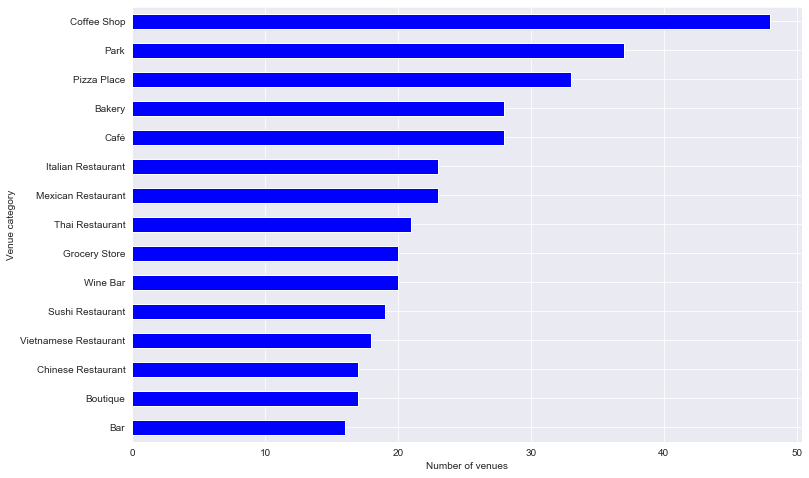

In [56]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(12,8))
sf_top_vc = sf_venues_df['Venue Category'].value_counts(normalize=False)
ax = sf_top_vc.head(15).plot(kind='barh',color = 'blue');
ax.invert_yaxis()
plt.xlabel('Number of venues')
plt.ylabel('Venue category')
#plt.tight_layout()
#fig.savefig('most-common-ven-sf.png', dpi=300)

In [57]:
#sf_top_vc = sf_venues_df['Venue Category'].value_counts(normalize=False)
#sf_top_vc = pd.DataFrame(sf_top_vc)

In [58]:
#plt.figure(figsize=(12,6))
#sns.heatmap(sf_top_vc.head(15),annot=True)

#### Most Common Venue Categories in Chicago

Text(0, 0.5, 'Venue category')

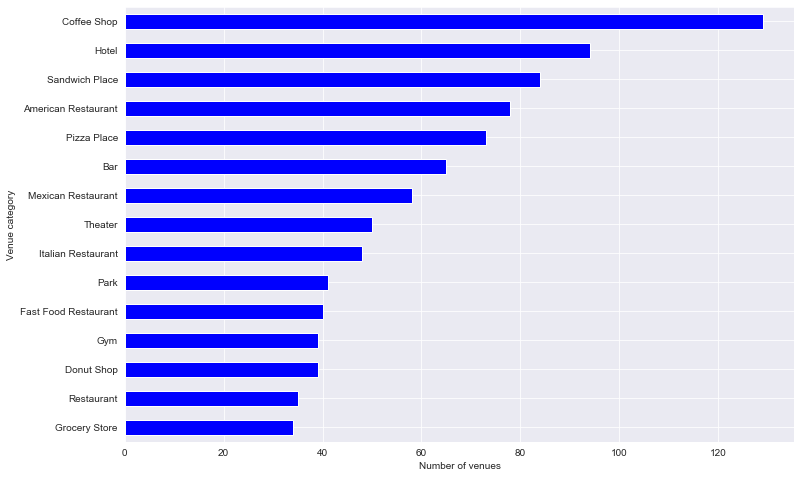

In [59]:
fig, ax = plt.subplots(figsize=(12,8))
ch_top_vc = ch_venues_data['Venue Category'].value_counts(normalize=False)
ax = ch_top_vc.head(15).plot(kind='barh',color = 'blue');
ax.invert_yaxis()
plt.xlabel('Number of venues')
plt.ylabel('Venue category')
#plt.tight_layout()
#fig.savefig('most-common-ven-sf.png', dpi=300)

#### Which Venue Categories Exist in More San Francisco Neighborhoods?

21 neighborhoods in NYC


Text(0, 0.5, 'Venue category')

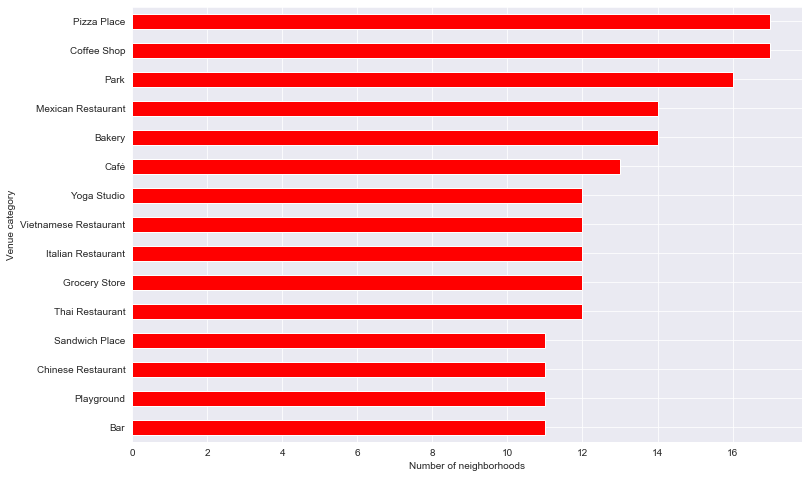

In [60]:
fig, ax = plt.subplots(figsize=(12,8))
sf_g = sf_onehot.groupby('Neighborhood').max().reset_index()
sf_p = sf_g.drop('Neighborhood', axis=1).sum().sort_values(ascending=False)
print("{} neighborhoods in NYC".format(sf_g.shape[0]))
ax = sf_p.head(15).plot(kind='barh', color='red');
ax.invert_yaxis()
plt.xlabel('Number of neighborhoods')
plt.ylabel('Venue category')
#plt.tight_layout()
#fig.savefig('most-common2-ven-nyc.png', dpi=300)

#### Which Venue Categories Exist in More Chicago Neighborhoods?

59 neighborhoods in NYC


Text(0, 0.5, 'Venue category')

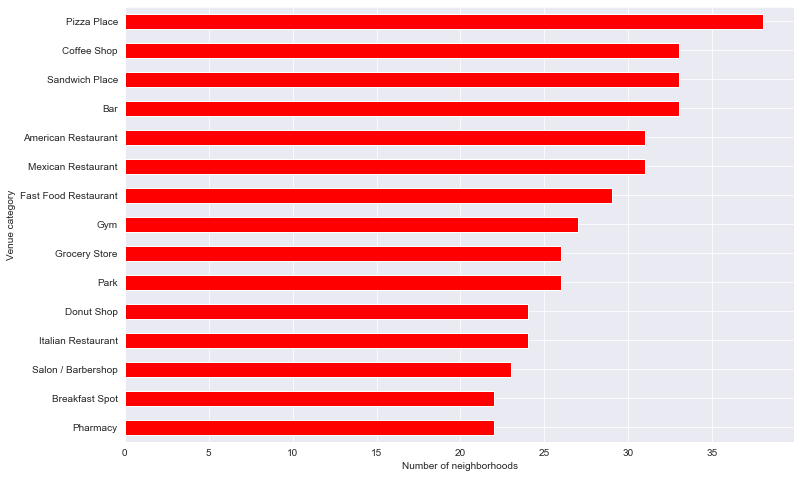

In [61]:
fig, ax = plt.subplots(figsize=(12,8))
ch_g = ch_onehot.groupby('Neighborhood').max().reset_index()
ch_p = ch_g.drop('Neighborhood', axis=1).sum().sort_values(ascending=False)
print("{} neighborhoods in NYC".format(ch_g.shape[0]))
ax = ch_p.head(15).plot(kind='barh', color='red');
ax.invert_yaxis()
plt.xlabel('Number of neighborhoods')
plt.ylabel('Venue category')
#plt.tight_layout()
#fig.savefig('most-common2-ven-nyc.png', dpi=300)

In [62]:
sf_cols = set(sf_grouped.columns).difference(set(ch_grouped.columns))
ch_cols = set(ch_grouped.columns).difference(set(sf_grouped.columns))

In [63]:
sf_grouped_ = sf_grouped.copy()
sf_grouped_['Neighborhood'] = sf_grouped_['Neighborhood'].apply(lambda x: x + '_SF')
ch_grouped_ = ch_grouped.copy()
ch_grouped_['Neighborhood'] = ch_grouped_['Neighborhood'].apply(lambda x: x + '_CH')

for c in sf_cols:
    ch_grouped_[c] = 0
for c in ch_cols:
    sf_grouped_[c] = 0
    
#all_cols_sorted = ['Neighborhood'] + sorted(list(sf_grouped_.drop('Neighborhood', axis=1).columns), key=str.lower)
#sf_grouped_ = sf_grouped_[all_cols_sorted]
#ch_grouped_ = ch_grouped_[all_cols_sorted]
    
sf_ch_grouped = pd.concat([sf_grouped_, ch_grouped_]).reset_index(drop=True)

In [340]:
sf_ch_grouped

,Neighborhood,ATM,Accessories Store,Adult Boutique,African Restaurant,Alternative Healer,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,...,Hobby Shop,Candy Store,Turkish Restaurant,Skate Park,Community Center,Malay Restaurant,College Residence Hall,Snack Place,Modern European Restaurant,Floating Market
0,Bayview-Hunters Point_SF,0.0,0.000000,0.000000,0.047619,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
1,Castro/Noe Valley_SF,0.0,0.000000,0.012658,0.000000,0.0,0.012658,0.000000,0.0,0.012658,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
2,Chinatown_SF,0.0,0.000000,0.000000,0.000000,0.0,0.034884,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
3,Haight-Ashbury_SF,0.0,0.024691,0.000000,0.000000,0.0,0.012346,0.012346,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
4,Hayes Valley/Tenderloin/North of Market_SF,0.0,0.010000,0.000000,0.000000,0.0,0.010000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,"Pullman, Roseland, Washington Heights, West Pu...",0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
76,Riverdale Chicago_CH,0.0,0.000000,0.000000,0.000000,0.0,0.050505,0.010101,0.0,0.000000,...,0.010101,0.0,0.0,0.0,0.000000,0.0,0.0,0.020202,0.0,0.0
77,Rogers Park_CH,0.0,0.000000,0.000000,0.021277,0.0,0.042553,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
78,South Shore_CH,0.0,0.000000,0.000000,0.000000,0.0,0.041667,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.041667,0.0,0.0,0.000000,0.0,0.0


In [65]:
###def return_most_common_venues(row, num_top_venues):
#    row_categories = row.iloc[1:]
#    row_categories_sorted = row_categories.sort_values(ascending=False)
    
#    return row_categories_sorted.index.values[0:num_top_venues]

In [66]:
# obtaining the most popular categories for each neighborhood
#num_top_venues=5
sf_ch_neigh_categories_sorted = pd.DataFrame(columns=columns)
sf_ch_neigh_categories_sorted['Neighborhood'] = sf_ch_grouped['Neighborhood']

for ind in np.arange(sf_ch_grouped.shape[0]):
    sf_ch_neigh_categories_sorted.iloc[ind, 1:] = return_most_common_venues(
        sf_ch_grouped.iloc[ind, :], num_top_venues)

sf_ch_neigh_categories_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bayview-Hunters Point_SF,Park,Southern / Soul Food Restaurant,Bakery,Fried Chicken Joint,Grocery Store,Thrift / Vintage Store,Theater,Latin American Restaurant,Market,Bus Station
1,Castro/Noe Valley_SF,Gay Bar,Coffee Shop,Park,Thai Restaurant,Scenic Lookout,Wine Bar,Playground,Cosmetics Shop,Seafood Restaurant,Indian Restaurant
2,Chinatown_SF,Hotel,Coffee Shop,Bakery,Bubble Tea Shop,Boutique,American Restaurant,Gym,Italian Restaurant,Sushi Restaurant,Restaurant
3,Haight-Ashbury_SF,Boutique,Coffee Shop,Clothing Store,Breakfast Spot,Shoe Store,Bookstore,Bus Station,Ice Cream Shop,Lingerie Store,Park
4,Hayes Valley/Tenderloin/North of Market_SF,Wine Bar,Boutique,New American Restaurant,Pizza Place,Clothing Store,Coffee Shop,Dessert Shop,Bakery,Food & Drink Shop,Burger Joint


In [341]:
sf_ch_neigh_categories_sorted

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Bayview-Hunters Point_SF,Park,Southern / Soul Food Restaurant,Bakery,Fried Chicken Joint,Grocery Store,Thrift / Vintage Store,Theater,Latin American Restaurant,Market,Bus Station
1,6,Castro/Noe Valley_SF,Gay Bar,Coffee Shop,Park,Thai Restaurant,Scenic Lookout,Wine Bar,Playground,Cosmetics Shop,Seafood Restaurant,Indian Restaurant
2,3,Chinatown_SF,Hotel,Coffee Shop,Bakery,Bubble Tea Shop,Boutique,American Restaurant,Gym,Italian Restaurant,Sushi Restaurant,Restaurant
3,6,Haight-Ashbury_SF,Boutique,Coffee Shop,Clothing Store,Breakfast Spot,Shoe Store,Bookstore,Bus Station,Ice Cream Shop,Lingerie Store,Park
4,6,Hayes Valley/Tenderloin/North of Market_SF,Wine Bar,Boutique,New American Restaurant,Pizza Place,Clothing Store,Coffee Shop,Dessert Shop,Bakery,Food & Drink Shop,Burger Joint
...,...,...,...,...,...,...,...,...,...,...,...,...
75,7,"Pullman, Roseland, Washington Heights, West Pu...",Fast Food Restaurant,Grocery Store,Sandwich Place,Electronics Store,Video Game Store,Bank,Chinese Restaurant,Gift Shop,Gourmet Shop,Indian Restaurant
76,3,Riverdale Chicago_CH,Coffee Shop,Hotel,Sandwich Place,Theater,American Restaurant,Donut Shop,Italian Restaurant,Restaurant,Department Store,Vegetarian / Vegan Restaurant
77,6,Rogers Park_CH,Mexican Restaurant,Pizza Place,Theater,Bus Station,American Restaurant,Bar,Mediterranean Restaurant,Bakery,Asian Restaurant,Dive Bar
78,6,South Shore_CH,Grocery Store,Pizza Place,Fried Chicken Joint,Cosmetics Shop,Seafood Restaurant,Bus Station,Food,Rental Car Location,Train Station,Record Shop


In [67]:
kclusters = 8 #set the number of clusters
sf_ch_grouped_clustering = sf_ch_grouped.drop('Neighborhood', axis=1)
# run k-means clustering
sf_ch_kmeans = KMeans(n_clusters=kclusters, random_state=1).fit(sf_ch_grouped_clustering)

In [68]:
# add clustering labels
sf_ch_neigh_categories_sorted.insert(0, 'Cluster Labels', sf_ch_kmeans.labels_)
# merge ch_grouped with ch_data to add latitude/longitude for each neighborhood
sf_ch_merged = sf_ch_neigh_categories_sorted.set_index('Neighborhood')


In [69]:
sf_ch_merged

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,,
Bayview-Hunters Point_SF,0,Park,Southern / Soul Food Restaurant,Bakery,Fried Chicken Joint,Grocery Store,Thrift / Vintage Store,Theater,Latin American Restaurant,Market,Bus Station
Castro/Noe Valley_SF,6,Gay Bar,Coffee Shop,Park,Thai Restaurant,Scenic Lookout,Wine Bar,Playground,Cosmetics Shop,Seafood Restaurant,Indian Restaurant
Chinatown_SF,3,Hotel,Coffee Shop,Bakery,Bubble Tea Shop,Boutique,American Restaurant,Gym,Italian Restaurant,Sushi Restaurant,Restaurant
Haight-Ashbury_SF,6,Boutique,Coffee Shop,Clothing Store,Breakfast Spot,Shoe Store,Bookstore,Bus Station,Ice Cream Shop,Lingerie Store,Park
Hayes Valley/Tenderloin/North of Market_SF,6,Wine Bar,Boutique,New American Restaurant,Pizza Place,Clothing Store,Coffee Shop,Dessert Shop,Bakery,Food & Drink Shop,Burger Joint
...,...,...,...,...,...,...,...,...,...,...,...
"Pullman, Roseland, Washington Heights, West Pullman_CH",7,Fast Food Restaurant,Grocery Store,Sandwich Place,Electronics Store,Video Game Store,Bank,Chinese Restaurant,Gift Shop,Gourmet Shop,Indian Restaurant
Riverdale Chicago_CH,3,Coffee Shop,Hotel,Sandwich Place,Theater,American Restaurant,Donut Shop,Italian Restaurant,Restaurant,Department Store,Vegetarian / Vegan Restaurant
Rogers Park_CH,6,Mexican Restaurant,Pizza Place,Theater,Bus Station,American Restaurant,Bar,Mediterranean Restaurant,Bakery,Asian Restaurant,Dive Bar


#### Add each cluster to a dataframe and plot the top 10 venues in each one

##### Cluster1

In [318]:
cluster1 = sf_ch_merged.loc[sf_ch_merged['Cluster Labels'] == 0, sf_ch_merged.columns[[1] + list(range(2, sf_ch_merged.shape[1]))]]

Text(0, 0.5, 'Venue category')

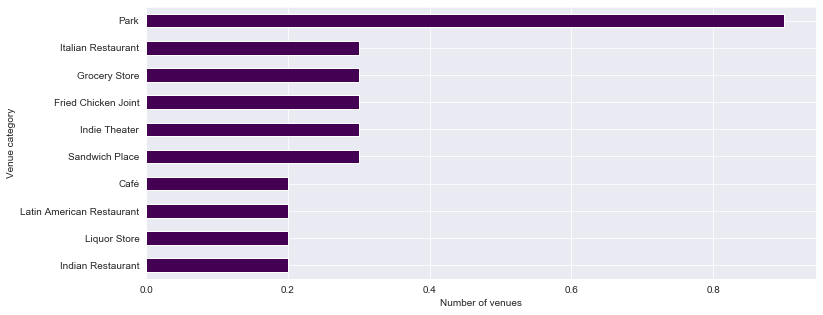

In [319]:
cluster1 = cluster1.apply(pd.value_counts).fillna(0) # replace the venues values to numeric. 
cluster1_t = cluster1.T # swap the columns with rows
cluster1_t.index.name = 'Venue' # rename the index
#cluster1_t.mean().sort_values(ascending=False).head(10)
# create a horizontal bar plot showing the top 10 venues and count their appearance on the cluster
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(12,5))
c1_top_vc = cluster1_t.mean().sort_values(ascending=False)
ax = c1_top_vc.head(10).plot(kind='barh',colormap = 'viridis')
ax.invert_yaxis()
plt.xlabel('Number of venues')
plt.ylabel('Venue category')

In [345]:
cluster1_t.mean().sort_values(ascending=False)

Park                     0.9
Italian Restaurant       0.3
Grocery Store            0.3
Fried Chicken Joint      0.3
Indie Theater            0.3
                        ... 
Hotpot Restaurant        0.1
Hotel                    0.1
Vietnamese Restaurant    0.1
Gym Pool                 0.1
Hookah Bar               0.1
Length: 63, dtype: float64

##### Cluster2

In [320]:
cluster2 = sf_ch_merged.loc[sf_ch_merged['Cluster Labels'] == 1, sf_ch_merged.columns[[1] + list(range(2, sf_ch_merged.shape[1]))]]

Text(0, 0.5, 'Venue category')

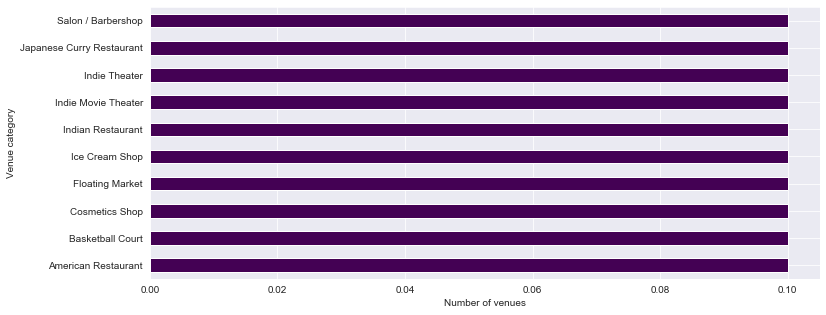

In [321]:
cluster2 = cluster2.apply(pd.value_counts).fillna(0) # replace the venues values to numeric. 
cluster2_t = cluster2.T # swap the columns with rows
cluster2_t.index.name = 'Venue' # rename the index
#cluster2_t.mean().sort_values(ascending=False).head(10)
# create a horizontal bar plot showing the top 10 venues and count their appearance on the cluster
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(12,5))
c2_top_vc = cluster2_t.mean().sort_values(ascending=False)
ax = c2_top_vc.head(10).plot(kind='barh',colormap = 'viridis')
ax.invert_yaxis()
plt.xlabel('Number of venues')
plt.ylabel('Venue category')

##### Cluster3

In [322]:
cluster3 = sf_ch_merged.loc[sf_ch_merged['Cluster Labels'] == 2, sf_ch_merged.columns[[1] + list(range(2, sf_ch_merged.shape[1]))]]

In [ ]:
cluster3 = cluster3.apply(pd.value_counts).fillna(0) # replace the venues values to numeric. 
cluster3_t = cluster3.T # swap the columns with rows
cluster3_t.index.name = 'Venue' # rename the index
#cluster3_t.mean().sort_values(ascending=False).head(10)
# create a horizontal bar plot showing the top 10 venues and count their appearance on the cluster
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(12,5))
c3_top_vc = cluster3_t.mean().sort_values(ascending=False)
ax = c3_top_vc.head(10).plot(kind='barh',colormap = 'viridis')
ax.invert_yaxis()
plt.xlabel('Number of venues')
plt.ylabel('Venue category')

##### Cluster4

In [324]:
cluster4 = sf_ch_merged.loc[sf_ch_merged['Cluster Labels'] == 3, sf_ch_merged.columns[[1] + list(range(2, sf_ch_merged.shape[1]))]]

Text(0, 0.5, 'Venue category')

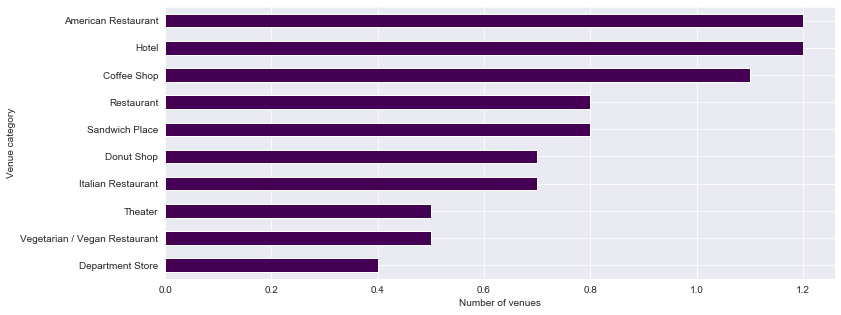

In [325]:
cluster4 = cluster4.apply(pd.value_counts).fillna(0) # replace the venues values to numeric. 
cluster4_t = cluster4.T # swap the columns with rows
cluster4_t.index.name = 'Venue' # rename the index
#cluster4_t.mean().sort_values(ascending=False).head(10)
# create a horizontal bar plot showing the top 10 venues and count their appearance on the cluster
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(12,5))
c4_top_vc = cluster4_t.mean().sort_values(ascending=False)
ax = c4_top_vc.head(10).plot(kind='barh',colormap = 'viridis')
ax.invert_yaxis()
plt.xlabel('Number of venues')
plt.ylabel('Venue category')

##### Cluster5

In [328]:
cluster5 = sf_ch_merged.loc[sf_ch_merged['Cluster Labels'] == 4, sf_ch_merged.columns[[1] + list(range(2, sf_ch_merged.shape[1]))]]

Text(0, 0.5, 'Venue category')

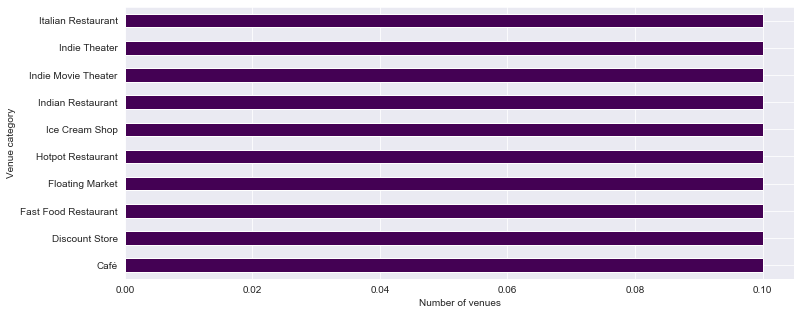

In [329]:
cluster5 = cluster5.apply(pd.value_counts).fillna(0) # replace the venues values to numeric. 
cluster5_t = cluster5.T # swap the columns with rows
cluster5_t.index.name = 'Venue' # rename the index
#cluster5_t.mean().sort_values(ascending=False).head(10)
# create a horizontal bar plot showing the top 10 venues and count their appearance on the cluster
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(12,5))
c5_top_vc = cluster5_t.mean().sort_values(ascending=False)
ax = c5_top_vc.head(10).plot(kind='barh',colormap = 'viridis')
ax.invert_yaxis()
plt.xlabel('Number of venues')
plt.ylabel('Venue category')

##### Cluster6

In [330]:
cluster6 = sf_ch_merged.loc[sf_ch_merged['Cluster Labels'] == 5, sf_ch_merged.columns[[1] + list(range(2, sf_ch_merged.shape[1]))]]

Text(0, 0.5, 'Venue category')

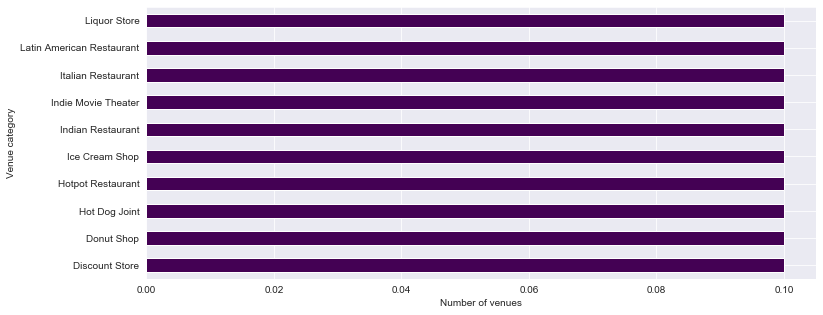

In [331]:
cluster6 = cluster6.apply(pd.value_counts).fillna(0) # replace the venues values to numeric. 
cluster6_t = cluster6.T # swap the columns with rows
cluster6_t.index.name = 'Venue' # rename the index
#cluster6_t.mean().sort_values(ascending=False).head(10)
# create a horizontal bar plot showing the top 10 venues and count their appearance on the cluster
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(12,5))
c6_top_vc = cluster6_t.mean().sort_values(ascending=False)
ax = c6_top_vc.head(10).plot(kind='barh',colormap = 'viridis')
ax.invert_yaxis()
plt.xlabel('Number of venues')
plt.ylabel('Venue category')

##### Cluster7

In [334]:
cluster7 = sf_ch_merged.loc[sf_ch_merged['Cluster Labels'] == 6, sf_ch_merged.columns[[1] + list(range(2, sf_ch_merged.shape[1]))]]

Text(0, 0.5, 'Venue category')

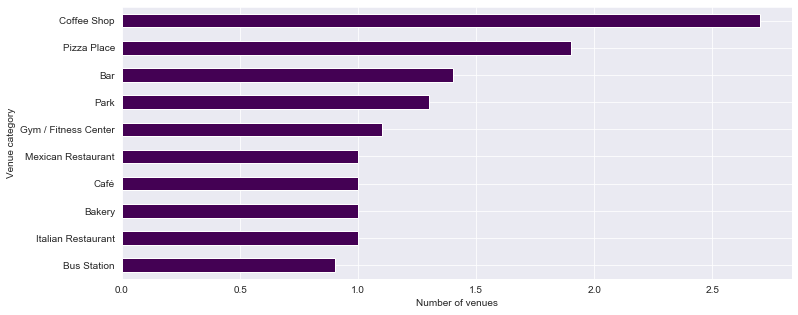

In [336]:
cluster7 = cluster7.apply(pd.value_counts).fillna(0) # replace the venues values to numeric. 
cluster7_t = cluster7.T # swap the columns with rows
cluster7_t.index.name = 'Venue' # rename the index
#cluster7_t.mean().sort_values(ascending=False).head(10)
# create a horizontal bar plot showing the top 10 venues and count their appearance on the cluster
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(12,5))
c7_top_vc = cluster7_t.mean().sort_values(ascending=False)
ax = c7_top_vc.head(10).plot(kind='barh',colormap = 'viridis')
ax.invert_yaxis()
plt.xlabel('Number of venues')
plt.ylabel('Venue category')

##### Cluster8

In [265]:
cluster8 = sf_ch_merged.loc[sf_ch_merged['Cluster Labels'] == 7, sf_ch_merged.columns[[1] + list(range(2, sf_ch_merged.shape[1]))]]

Text(0, 0.5, 'Venue category')

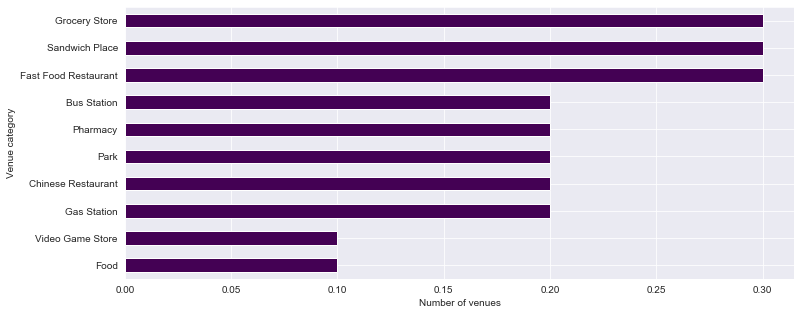

In [337]:
cluster8 = cluster8.apply(pd.value_counts).fillna(0) # replace the venues values to numeric. 
cluster8_t = cluster8.T # swap the columns with rows
cluster8_t.index.name = 'Venue' # rename the index
#cluster8_t.mean().sort_values(ascending=False).head(10)
# create a horizontal bar plot showing the top 10 venues and count their appearance on the cluster
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(12,5))
c8_top_vc = cluster8_t.mean().sort_values(ascending=False)
ax = c8_top_vc.head(10).plot(kind='barh',colormap = 'viridis')
ax.invert_yaxis()
plt.xlabel('Number of venues')
plt.ylabel('Venue category')

In [346]:
sf_ch_merged['Cluster Labels'].value_counts()

6    41
3    13
2    11
0     9
7     3
5     1
4     1
1     1
Name: Cluster Labels, dtype: int64